# Log Colorizer
Learn from statistical properties in a trace of logs

In [1]:
from eliana.preprocessing import LogColorizer
from nb_utils import showAttribs, draw_heatmap
showAttribs(LogColorizer)

LogColorizer        : Model to learn tokenizers from a dataset of traces.

Constructor
__init__            : Initializes the LogColorizer with a tokenizer or a custom tokenization function.

Properties
regexps             : List of regular expressions used by the tokenizer, including post-processing patterns.
special             : Symbol used as a placeholder for numeric or variable values in templates. Default is '§'.
templates           : List of templates used for matching traces.
wildcard            : Placeholder for variable text in templates. Default is "{}".

Methods
fit                 : Learns templates and tokenization rules from a dataset of traces.
fit_on_traces       : None
save                : Saves the tokenizer object to a file.
tokenize            : Tokenizes a word or phrase using the provided tokenizer and post-processing steps.


## Example with ParlogsObservations

### Imports

In [2]:
import pandas as pd
from collections import Counter
import numpy as np

from eliana.datasets import ParlogsObservations
from eliana.preprocessing import LogColorizer, VltTokenizer, load_tokenizer
from eliana.preprocessing.utils import measure_color_growth


### Load Event Logs

In [3]:
logs = ParlogsObservations(system="PIONIER", period="1w")
traces = logs.traces()

print(f"About to colorize {len(traces)} traces over col=logtext, which has uniques={len(traces['logtext'].unique())}")

About to colorize 89408 traces over col=logtext, which has uniques=19412


The base tokenizer will be VltTokenizer which include some regexps specific to Paranal use case.

In [4]:
print(VltTokenizer().help())

Tokenizer class "VltTokenizer"
Inherits from: UTCdate, Numbers, Punctuation, RegExpTokenizer
Options: namespace(remove_extra_spaces=True, to_lowercase=True, strip=True)

Tokenization is done in the following order

UTCdate: Transform UTC dates using {} as token
    2022-10-01T00:43:01.123 -> {}
    Started at 2019-04-01T22:29:07 (underlined) -> Started at {} (underlined)

Numbers: Transform numbers using {} as token, but ignore numbers that are parts of a word
    1 -> {}
    -10.54 -> {}
    9.1e-2.1 -> {}
    There are 2 telescopes: UT1, UT2 -> There are {} telescopes: UT1, UT2
    2Good2be_True -> 2Good2be_True

Punctuation: Remove all punctuation
    Original: Hi! I'm counting 1,2, 3 ... and so on.
    Tokenized: Hi I m counting 1 2 3 and so on

RegExpTokenizer:     A tokenizer that uses regular expressions to tokenize text. Inherits from AbstractTokenizer.

VltTokenizer: Domain specific transformation for Paranal VLT software logs using {} as token
    Original : wat2tcs lt3aga w2

In [5]:
%%time
model = LogColorizer(tokenizer=VltTokenizer())
_ = model.fit(traces, warn=True)


CPU times: user 11.3 s, sys: 231 ms, total: 11.5 s
Wall time: 11.6 s


In [6]:
# See learnt tokenization in action. Use swifter for faster processing if you need
#!pip install swifter
#traces['colorized'] = traces['event'].swifter.apply(lambda x: model.tokenize(x))

traces['colorized'] = traces['event'].apply(lambda x: model.tokenize(x))
traces['color_id'] = traces['colorized'].apply(lambda x: model.vocab_dict_.get(x, model.vocab_dict_['<unk>']))

traces[['event', 'colorized', 'color_id']][50:70]

,event,colorized,color_id
50,LOG pnoControl Reply (not last) to 'STATUS' ...,log pnocontrol reply not last to status receiv...,39
51,"LOG bob_25299 INS.MODE ""OBSERV-H"" (SpringGre...",log bob_{} ins mode observ h springgreen4,40
52,LOG bob_25299 beginning exposure 1 of 1 (201...,log bob_{} beginning exposure {} of {} {} unde...,41
53,LOG bob_25299 SETUP -expoId 0 -function INS....,log bob_{} setup expoid {} function ins mode o...,42
54,LOG pnoControl Executing SETUP command ...,log pnocontrol executing setup command,12
55,LOG pnoControl Forward(b) SETUP to DCS,log pnocontrol forward b {} to dcs,13
56,LOG ic0fbControl_1 1 - ic0fbControlSrv.C:695...,log ic0fbcontrol_1 {} ic0fbcontrolsrv c {} cha...,16
57,FEVT logManager INS.OPTI1.MOVE Motion execution.,fevt logmanager ins opti1 move motion execution,18
58,LOG ic0fbDev_CFOU 1 - ic0fbiDevDrvDiscreteMo...,log ic0fbdev_cfou {} ic0fbidevdrvdiscretemotor...,29
59,LOG ic0fbControl_1 1 - ic0fbControlSrv.C:695...,log ic0fbcontrol_1 {} ic0fbcontrolsrv c {} cha...,19


### Save the tokenizer

In [7]:
model.save('data/models/example_logcolorizer.pkl')
!ls -lh data/models/

total 520
-rw-r--r--  1 jgil  5000   250K Jan  2 11:48 example_logcolorizer.pkl


### Load the tokenizer

In [8]:
model = load_tokenizer('data/models/example_logcolorizer.pkl')
model.vocab_dict_['<unk>']

0

### Color growth

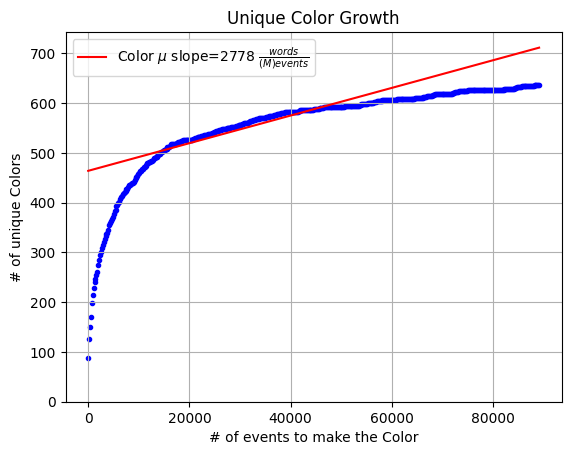

In [9]:
words = [ word  for row in model.traces_.keys() for word in model.traces_[row] ]
df = pd.DataFrame( { 'words': words })

_ = measure_color_growth(df['words'], plot=True, title=None, retplot=True)


### Word Frequency heatmap

In [10]:
len(model.traces_)

394

In [11]:
traces_coloured = []
for k, row in model.traces_.items():
    frequencies = Counter( row )
    trace_encoded = { k: 0 for k in model.vocab_dict_.values() }
    trace_encoded.update(frequencies) ## [freq(word_1), ..., freq(word_n)]
    traces_coloured.append( list(trace_encoded.values()) )

matrix = np.asarray(traces_coloured) 

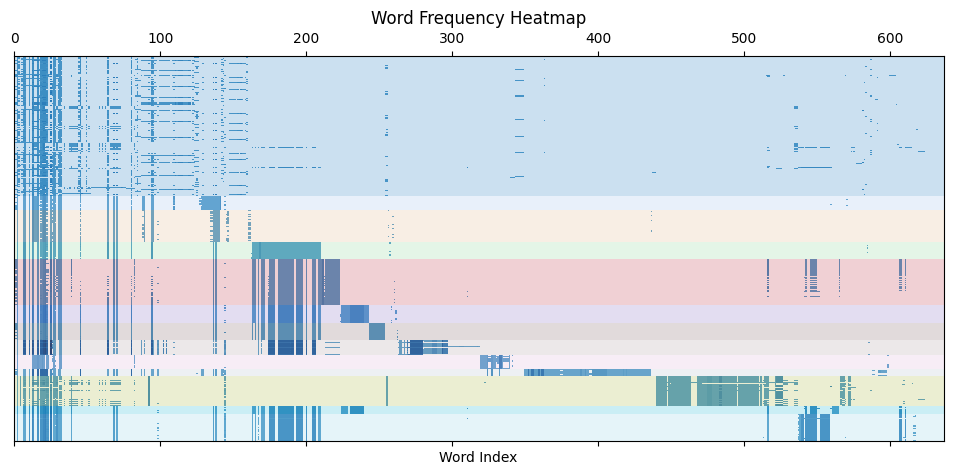

In [12]:
_ = draw_heatmap(matrix)

### Inspect inner workings of the model

In [13]:
print(f"""
Num of regexps  : {len(model.regexps)}
Num of templates: {len(model.templates)}
Vocabulary size : {len(model.vocab_dict_)}
""")


Num of regexps  : 10
Num of templates: 23
Vocabulary size : 637



In [14]:
# First 20 items of the vocabulary
list(model.vocab_dict_.items())[:20]

[('<unk>', 0),
 ('log bob_ins pionier_gen_{} {} {} yellow', 1),
 ('log bob_ins started at {} underlined', 2),
 ('log bob_ins seq win single f', 3),
 ('log bob_ins ins mode observ h', 4),
 ('log bob_ins ins disp name free', 5),
 ('log bob_ins status function ins mode blue', 6),
 ('log pnocontrol send command status ins mode false to sub system ics', 7),
 ('log pnocontrol reply not last to status received ins mode park len {} last reply will be ignored',
  8),
 ('log bob_ins ins mode park springgreen4', 9),
 ('log bob_ins beginning exposure {} of {} {} underlined', 10),
 ('log bob_ins setup expoid {} function ins mode park det scan st f blue', 11),
 ('log pnocontrol executing setup command', 12),
 ('log pnocontrol forward b {} to dcs', 13),
 ('log ic0fbcontrol_1 {} ic0fbinsmodel c {} notice irrelevant setup key received ins shut{} st',
  14),
 ('log ic0fbcontrol_1 {} ic0fbinsmodel c {} notice irrelevant setup key s contained in setup buffer',
  15),
 ('log ic0fbcontrol_1 {} ic0fbcontrols

In [15]:
model.regexps

[('([lw]a{0,1}t)[0-9]([a-z]+)', '\\1{}\\2'),
 ('(\\W)cmd\\d+', '\\1cmd{}'),
 ('(\\s*?[a-z][a-z0-9]{2,})_[0-9]{3,}(\\s*)', '\\1_{}\\2'),
 ('\\.\\.\\.(\\s+\\S+){5}.*', '_setup_parameters_ommited_'),
 ('\\d{4}-\\d{2}-\\d{2}[ tT]\\d{2}:\\d{2}:\\d{2}(\\.\\d{0,3})?', '{}'),
 ('\\b-?\\d+(\\.\\d+)?([eE][-+]?\\d+(\\.\\d+)?)?\\b', '{}'),
 ('-{}', '{}'),
 ('[\\"\'!,;:\\+\\*\\$<>\\.\\-|/\\\\=\\[\\]\\()#]', ' '),
 ('(\\{\\})+', '{}'),
 [('(\\{\\})+', '{}'),
  (' [0-9]+x[0-9]+a[0-9]+ ', ' {}x{}a{} '),
  (' [0-9]+xf[0-9]+ ', ' {}xf{} '),
  (' [0-9]+pho ', ' {}pho '),
  (' [0-9]+x[0-9]+ ', ' {}x{} '),
  (' a[0-9]+ ', ' a{} '),
  (' beam[0-9]+ ', ' beam{} '),
  (' cfg[0-9]+ ', ' cfg{} '),
  (' cs[0-9]+ ', ' cs{} '),
  (' cu[0-9]+ ', ' cu{} '),
  (' dpnics[0-9]+ ', ' dpnics{} '),
  (' g[0-9]+ ', ' g{} '),
  (' ic[0-9]+fbcontrolsrv_standbycb ', ' ic{}fbcontrolsrv_standbycb '),
  (' ic[0-9]+fbdev_ccool ', ' ic{}fbdev_ccool '),
  (' ic[0-9]+fbdev_cryo ', ' ic{}fbdev_cryo '),
  (' ic[0-9]+fbdev_disp ', ' ic

In [16]:
model.templates

['flog logmanager ins cfg{} ttm§ xref {}',
 'flog logmanager ins cfg{} ttm§ yref {}',
 'log bob_ins det § § {} springgreen4',
 'log bob_ins ins2 ttm§ xref {} springgreen4',
 'log bob_ins ins2 ttm§ yref {} springgreen4',
 'log pnocontrol forward a § to dcs',
 'log pnocontrol forward b § to dcs',
 'log bob_ins status function det § § blue',
 'log bob_ins status function ins2 § § blue',
 'log ic0fbcontrol_1 {} ic0fbcontrolsrv c {} device § changed state from standby to standby',
 'log unknown send a{} no kill mjaxos{}wnc{}w§ reply to {}',
 'err § evherr_error_handling this error stack contain not handled errors forcing closestack',
 'log ic§ {} ic0fbdevsrv_standbycb c {} brought device § to standby state',
 'log pnocontrol last reply to status from acs received ins2 ttm§ xref {} len {}',
 'log pnocontrol last reply to status from acs received ins2 ttm§ yref {} len {}',
 'log pnocontrol last reply to status from dcs received det § § {} len {}',
 'flog logmanager det dl§ zeroopd {}',
 'log 